In [270]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [271]:
0.8 * 0.8 * 30

19.200000000000003

In [272]:
from enum import Enum

In [273]:
class Point:
    def __init__(self):
        self.x = None
        self.y = None
        self.z = None

        self.id = None


In [274]:
class CLASSIFIED_STATUS(Enum):
    SUCCESS = 0
    UNCLASSIFIED = -1
    NOISE = -2
    FAILURE = -3

#class CLASSIFIED_STATUS:
#    def __init__(self):
#        self.SUCCESS = 0
#        self.UNCLASSIFIED = -1
#        self.NOISE = -2
#        self.FAILURE = -3

class POINT_STATUS(Enum):
    CORE_POINT      = 1
    BORDER_POINT    = 2
    OTHER           = 0


In [275]:
class DBSCAN:
    def __init__(self, points, min_points_th, max_points_th, eps):
        self.__min_points_th    = min_points_th
        self.__epsiron          = eps
        self.__points           = points
        self.__points_size      = len(points)

        self.__max_points_th    = max_points_th

        self.__cluster_size     = None

        
    
    def Run(self):
        cluster_id = 1

        for point in self.__points:
            if point.cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED:
                if self.ExpandCluster(point, cluster_id) != CLASSIFIED_STATUS.FAILURE:
                    cluster_id = cluster_id + 1
        self.__cluster_size = cluster_id
        return(cluster_id)

    def CalcurateCluster(self, point):
        cluster_index = []
        index = 0
        #print("Search from (",point.x,",", point.y, ")")
        for p in self.__points:
            if self.CalcurateDistance(point, p) <= self.__epsiron:
                cluster_index.append(index)
                #print("\t Point ", index, "(", p.x, ",", p.y, ") Added")
                
                # Max Cluster Size
                #if len(cluster_index) >= self.__max_points_th:
                #    break
            
            index = index + 1
            
        return(cluster_index)

    def ExpandCluster(self, point, cluster_id):
        #print("Cluster:", cluster_id, " Start Espansion")
        seeds = self.CalcurateCluster(point)
        #print(seeds)
        #if point.cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
        #    and len(seeds) < self.__min_points_th:
        if len(seeds) < self.__min_points_th:
            #point.cluster_id = 100
            point.cluster_id = CLASSIFIED_STATUS.NOISE
            #print("Finished as Noise")
            return(CLASSIFIED_STATUS.FAILURE)

        index = 0
        index_core_point = 0

        for seed in seeds:
            if self.__points[seed].cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
                or self.__points[seed].cluster_id == CLASSIFIED_STATUS.NOISE:

                self.__points[seed].cluster_id = cluster_id
                #print("\t", cluster_id, ":", self.__points[seed].x, ",", self.__points[seed].y)

                if self.CheckSamePoint(self.__points[seed], point) == True:
                    index_core_point = index
                index = index + 1

        #seeds[index_core_point] = seeds.pop(-1)

        #for i in range(len(seeds)):
        i = 0
        while i < len(seeds):
            # Range Search
            #print("Cluster:", cluster_id, " Neighbor Search :: Seed", seeds[i])
            cluster_neighbors = self.CalcurateCluster(self.__points[seeds[i]])

            if len(cluster_neighbors) >= self.__min_points_th:
                #self.__points[seeds[i]].cluster_id = cluster_id
                for neighbor in cluster_neighbors:            
                    #print(len(seeds))
                    
                    # Max Cluster Size

                    if self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.UNCLASSIFIED \
                        or self.__points[neighbor].cluster_id == CLASSIFIED_STATUS.NOISE:
                        seeds.append(neighbor)
                        self.__points[neighbor].cluster_id = cluster_id
                        #print("\t", cluster_id, ":", self.__points[neighbor].x, ",", self.__points[neighbor].y)
                        #print("\t", seeds)

                    if len(seeds) >= self.__max_points_th:
                        return(CLASSIFIED_STATUS.SUCCESS)

            i = i+1

        return(CLASSIFIED_STATUS.SUCCESS)
        



    def CalcurateDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        dz = point_target.z - point_core.z

        distance = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
        return(distance)

    def CheckSamePoint(self, point1, point2):
        distance = self.CalcurateDistance(point1, point2)
        if distance < 0.01:
            return(True)
        else:
            return(False)

    def CalcurateDoubleDistance(self, point_core, point_target):
        dx = point_target.x - point_core.x
        dy = point_target.y - point_core.y
        dz = point_target.z - point_core.z

        double_distance = dx ** 2 + dy ** 2 + dz ** 2
        return(double_distance)

    def GetTotalPointSize(self):
        return(self.__point_size)

    def GetMinimumClusterSize(self):
        return(self.__min_points_th)
    
    def GetEpsilon(self):
        return(self.__epsiron)

    def GetPoints(self):
        return(self.__points)

    def GetClusterSize(self):
        return(self.__cluster_size)



In [276]:
import random


In [277]:
raw_points = [
    [1.0,1.0,0],
    [1.0,0.5,0],
    [0.5,1.0,0],
    [1.0,1.5,0],

    [3.0,3.0,0],
    [3.0,3.5,0],
    [3.5,3.0,0],
    [3.5,3.5,0],

    [3.0,5.0,0],
    [3.0,5.5,0],
    [3.5,5.0,0],
    [3.5,5.5,0],

    [10.0,10.0,0],
    [10.0,10.5,0],
    [10.5,10.0,0],
    [10.5,10.5,0],

    [15.0,15.0,0],
    [15.0,15.5,0],
    [15.5,15.0,0],
    [15.5,15.5,0],

    [0.0,15.0,0],
    [0.0,15.5,0],
    [0.5,14.0,0],
    [0.5,13.0,0],

    [10.0, 10.0,0],
    [10.0, 11.5,0],
    [10.0, 9.0,0],
    [10.0, 8.0,0],

    [4.0,3.0,0],
    [5.0,3.5,0],
    [4.5,2.5,0],
    [5.5,3.0,0],

    [15.0, 5.0,0],
    [15.0, 5.5,0],
    [15.0, 7.0,0],
    [15.0, 8.0,0],

    [1.0, 5.0,0],
    [1.0, 5.5,0],
    [1.0, 7.0,0],
    [1.0, 8.0,0]

]

points = [Point() for i in range(len(raw_points))]
for i in range(len(raw_points)):
    p = Point()
    p.x = raw_points[i][0]
    p.y = raw_points[i][1]
    p.z = raw_points[i][2]
    p.cluster_id = CLASSIFIED_STATUS.UNCLASSIFIED
    points[i] = p

In [278]:
points = [Point() for i in range(300)]
for i in range(len(points)):
    points[i].x = random.uniform(0,30)
    points[i].y = random.uniform(0,30)
    points[i].z = 0
    points[i].cluster_id = CLASSIFIED_STATUS.UNCLASSIFIED

In [279]:
min_points_th = 2
max_points_th =  100
eps = 2.0

In [280]:
db = DBSCAN( points, min_points_th, max_points_th, eps)

In [281]:
db.Run()

17

In [282]:
db_points = db.GetPoints()
db_cluster_num = db.GetClusterSize()
print(db_cluster_num)
for i in range(len(db_points)):
    if db_points[i].cluster_id == CLASSIFIED_STATUS.NOISE:
        db_points[i].cluster_id = db_cluster_num
        db_cluster_num = db_cluster_num + 1

print("after:",db_cluster_num)
        

17
after: 26


In [283]:
for p in db_points:
    print("(", p.x, ", ", p.y, ", ", p.z, ") : ", p.cluster_id)

( 27.575353096049415 ,  24.802837872613495 ,  0 ) :  1
( 1.2139391395228416 ,  21.092943525838816 ,  0 ) :  2
( 20.950197000799726 ,  2.6122524316618554 ,  0 ) :  3
( 23.420962965202005 ,  10.347762801537248 ,  0 ) :  4
( 27.939677090598607 ,  19.18286500715591 ,  0 ) :  5
( 22.73627752324437 ,  17.914307714637864 ,  0 ) :  1
( 1.2867774138703836 ,  22.47681580314668 ,  0 ) :  2
( 25.4122183955566 ,  28.189502026472468 ,  0 ) :  6
( 9.828387584292464 ,  22.645328043798916 ,  0 ) :  1
( 19.623697126026588 ,  5.859426379590239 ,  0 ) :  3
( 4.300855431742161 ,  8.37374266845831 ,  0 ) :  7
( 2.760639938287773 ,  22.504765961149317 ,  0 ) :  2
( 9.105206889759458 ,  22.510434225295217 ,  0 ) :  1
( 25.557150448375374 ,  21.81831797505598 ,  0 ) :  1
( 12.689575598039296 ,  22.431468097237055 ,  0 ) :  1
( 6.049791079676482 ,  0.6496506697164051 ,  0 ) :  3
( 22.773981421802723 ,  5.925192920847341 ,  0 ) :  3
( 21.073204714122163 ,  9.150041649953813 ,  0 ) :  3
( 8.331486166782597 ,  2.0

In [284]:
import matplotlib.cm as cm

In [285]:

x = []
y = []
cluster = []
#cluster_size = db.GetClusterSize()
cluster_size = db_cluster_num
for p in db_points:
    x.append(p.x)
    y.append(p.y)
    if p.cluster_id == CLASSIFIED_STATUS.NOISE:
        print("Noise removed")
        p.cluster_id = -2
    cluster.append(p.cluster_id / cluster_size)

cluster



[0.058823529411764705,
 0.11764705882352941,
 0.17647058823529413,
 0.23529411764705882,
 0.29411764705882354,
 0.058823529411764705,
 0.11764705882352941,
 0.35294117647058826,
 0.058823529411764705,
 0.17647058823529413,
 0.4117647058823529,
 0.11764705882352941,
 0.058823529411764705,
 0.058823529411764705,
 0.058823529411764705,
 0.17647058823529413,
 0.17647058823529413,
 0.17647058823529413,
 0.17647058823529413,
 0.058823529411764705,
 0.4117647058823529,
 0.058823529411764705,
 0.058823529411764705,
 0.47058823529411764,
 0.058823529411764705,
 0.23529411764705882,
 1.0,
 0.058823529411764705,
 0.17647058823529413,
 0.058823529411764705,
 0.17647058823529413,
 0.058823529411764705,
 0.11764705882352941,
 1.0588235294117647,
 0.058823529411764705,
 0.17647058823529413,
 0.058823529411764705,
 0.058823529411764705,
 0.11764705882352941,
 0.058823529411764705,
 0.17647058823529413,
 0.4117647058823529,
 0.11764705882352941,
 0.17647058823529413,
 0.17647058823529413,
 0.2352941176

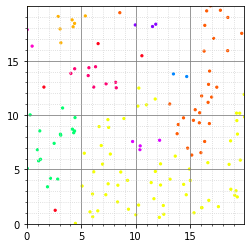

In [286]:
fig, ax = plt.subplots()
ax.scatter(x=x, y=y, color = cm.hsv(cluster), s = 5)
max_x = 20
max_y = 20
ax.set_xlim(0,max_x)
ax.set_ylim(0,max_y)

x_minor_ticks = np.arange(0,max_x,1)
x_major_ticks = np.arange(0,max_x,5)
y_minor_ticks = np.arange(0,max_y,1)
y_major_ticks = np.arange(0,max_y,5)

ax.set_xticks(x_minor_ticks, minor=True)
ax.set_xticks(x_major_ticks, minor=False)
ax.set_yticks(y_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks, minor=False)

ax.grid(which="major", color="gray", linestyle="solid")
ax.grid(which="minor", color="lightgray", linestyle="dotted")
ax.set_aspect('equal')

In [287]:
def SavePoints(filedir, points, partition = ","):
    with open(filedir, "w") as f:
        f.write(str(len(points))+"\n")
        for point in points:
            str_data = str(point.x) + partition + str(point.y) + partition + str(point.z) + partition + str(point.cluster_id) + "\n"
            f.write(str_data)

In [288]:
SavePoints("./sample_pcl.xyz", points, partition=" ")